<a href="https://colab.research.google.com/github/evmpython/estacoes_meteorologicas/blob/main/04_download_via_API_estacoes_CEMADEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DOWNLOAD DOS DADOS DAS ESTAÇÕES METEOROLÓGICAS DO `CEMADEN`**

---
- Para processar esse código será necessário solicitar ao CEMADEN via e-mail (ped@cemaden.gov.br) o login e senha.

- O acesso é realizado via Plataforma de Entrega de Dados (PED): http://ped.cemaden.gov.br/

- Informações sobre as estações: http://ped.cemaden.gov.br/ConsultarRedeEstacoes

---


- Código realizado por: Enrique V. Mattos -- 13/05/2024 - enrique@unifei.edu.br.

---

#**Estações do CEMADEN disponíveis**

In [1]:
# baixa a lista das estações
!wget -c https://raw.githubusercontent.com/evmpython/estacoes_meteorologicas/main/input/lista_das_estacoes_CEMADEN_13maio2024.csv

# leitura do planilha
import pandas as pd
df_estacoes = pd.read_csv('/content/lista_das_estacoes_CEMADEN_13maio2024.csv')
df_estacoes.drop('Unnamed: 0', axis=1, inplace=True)
df_estacoes.rename(columns={'Código': 'codigo', 'Nome': 'nome', 'Latitude': 'lat', 'Longitude': 'lon'}, inplace=True)
df_estacoes.head(2)

--2024-05-13 18:46:16--  https://raw.githubusercontent.com/evmpython/estacoes_meteorologicas/main/input/lista_das_estacoes_CEMADEN_13maio2024.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165975 (162K) [text/plain]
Saving to: ‘lista_das_estacoes_CEMADEN_13maio2024.csv’

lista_das_estacoes_ 100%[===================>] 162.08K  --.-KB/s    in 0.02s   

2024-05-13 18:46:16 (6.83 MB/s) - ‘lista_das_estacoes_CEMADEN_13maio2024.csv’ saved [165975/165975]



,codigo,nome,lat,lon
0,530010805A,Nucleo Bandeirante,-15.8768,-47.9627
1,530010804A,Sobradinho,-15.6237,-47.8469


In [2]:
print('Quantidade de estações do CEMADEN=', f'{df_estacoes.shape[0]} estações')

Quantidade de estações do CEMADEN= 3110 estações


# **Download dos dados**
Para realizar o download dos dados deverá ser informado:



- LOGIN e SENHA passado pelo CEMADEN

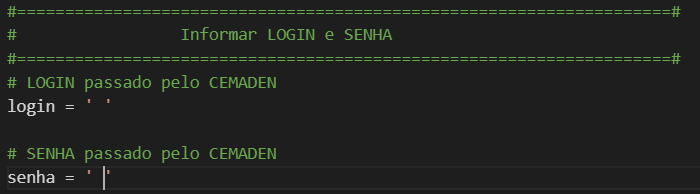

- Código da estação
- Sigla do Estado da Federação que pertence a estação
- Ano e Mês inicial e final

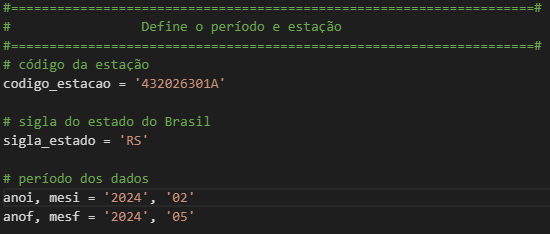

- 1) Indicar o `Estado` e `código` da estação. Para isto você deverá acessar a [página](http://www2.cemaden.gov.br/mapainterativo/#) do CEMADEN e clicar em *Estações* localizado na parte superior da página e depois em *Pluviometros Automáticos*, como mostrado na figura abaixo. Basta passar o Mouse sobre a estação e anotar o código.

- 2) Indicar o `Ano` e `Mês` inicial e final.


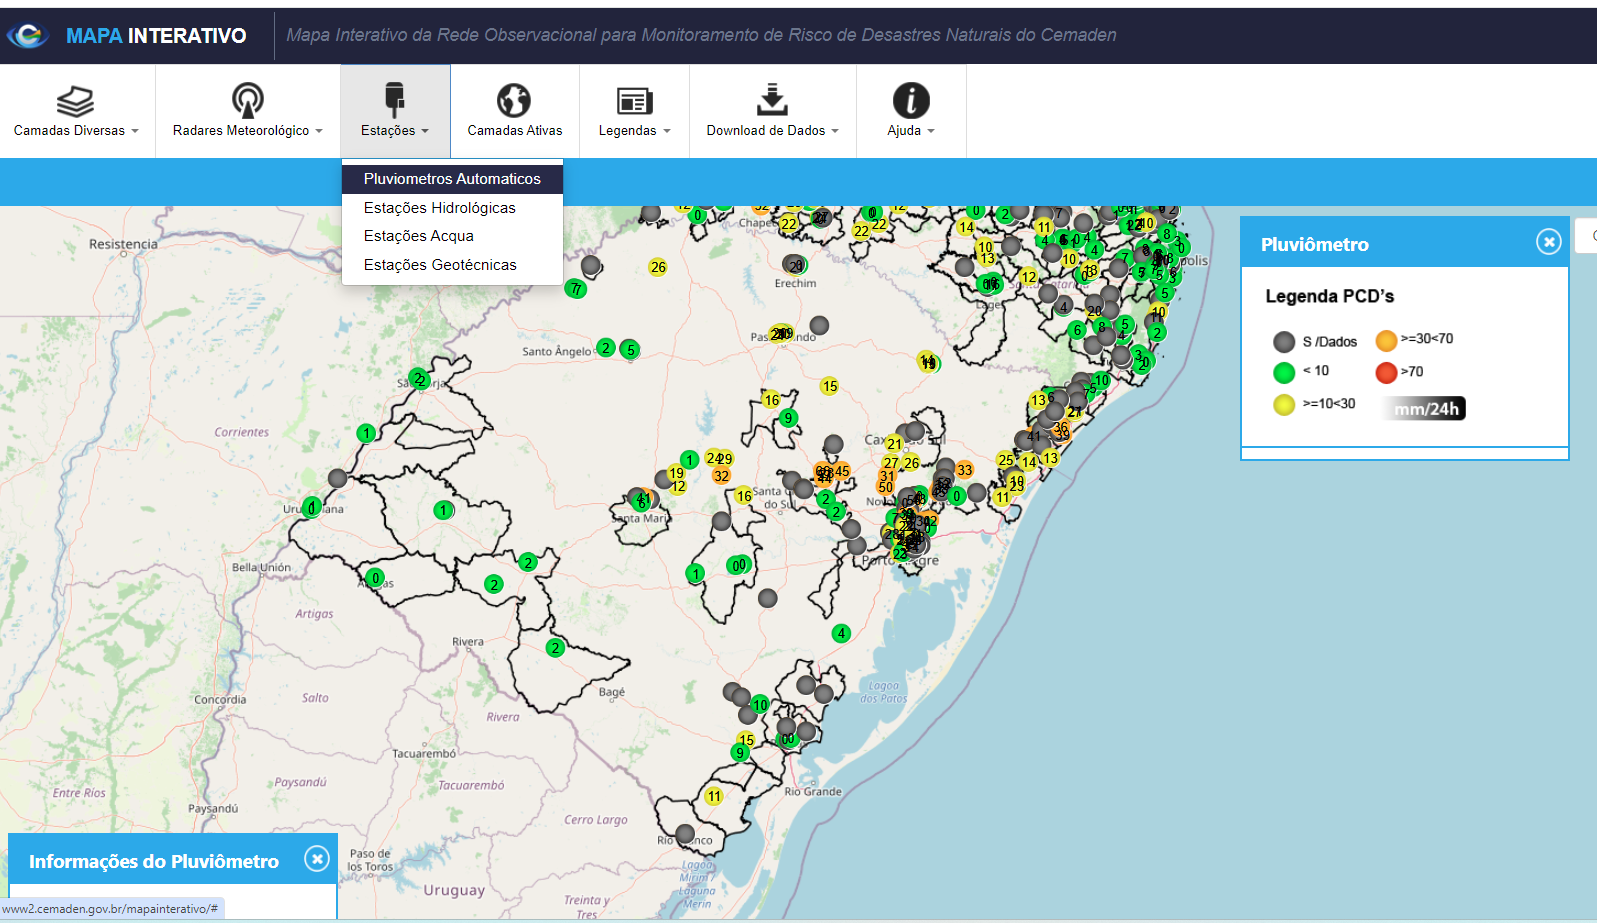

In [5]:
#====================================================================#
#                 Importa bibliotecas
#====================================================================#
import pandas as pd
import requests
import glob
import calendar
import os
import warnings
warnings.filterwarnings("ignore")

# remove arquivos anteriores
!rm /content/estacao_CEMADEN_*.csv

#====================================================================#
#                 Informar LOGIN e SENHA
#====================================================================#
# LOGIN passado pelo CEMADEN
login = ' '

# SENHA passado pelo CEMADEN
senha = ' '

#====================================================================#
#                 Define o período e estação
#====================================================================#
# código da estação
codigo_estacao = '432026301A'

# sigla do estado do Brasil
sigla_estado = 'RS'

# período dos dados
anoi, mesi = '2024', '02'
anof, mesf = '2024', '05'

diai = '01'
diaf = str(calendar.monthrange(int(anof), int(mesf))[1])
data_inicial, data_final = f'{anoi}{mesi}{diai}', f'{anof}{mesf}{diaf}'

#====================================================================#
#           Recuperação do token usando Python
#====================================================================#
token_url = 'http://sgaa.cemaden.gov.br/SGAA/rest/controle-token/tokens'

login = {'email': login, 'password': senha}
response = requests.post(token_url, json=login)
content = response.json()
token = content['token']

#====================================================================#
#               Download dos arquivos por mês
#====================================================================#
for ano_mes_dia in pd.date_range(data_inicial, data_final, freq='1M'):

    #------------------------------------------#
    #          Extrai o ano e mês
    #------------------------------------------#
    ano_mes = ano_mes_dia.strftime('%Y%m') #'202401'

    #------------------------------------------#
    #    Requisição de dados usando Python
    #------------------------------------------#
    sws_url = 'http://sws.cemaden.gov.br/PED/rest/pcds/dados_pcd'
    params = dict(rede=11, uf=sigla_estado, inicio=ano_mes, fim=ano_mes, codigo=codigo_estacao) #data = '202404' e #codigo = '431490201A'
    r = requests.get(sws_url, params=params, headers={'token': token})
    dados = r.text

    #------------------------------------------#
    #           Escrita do arquivo
    #------------------------------------------#
    with open(f'/content/estacao_CEMADEN_{sigla_estado}_{codigo_estacao}_{ano_mes}.csv','w') as arquivo:
        for dado in dados:
            arquivo.write(str(dado))

#====================================================================#
#               Junta num arquivo CSV
#====================================================================#
# lista os arquivos
files = sorted(glob.glob(f'/content/estacao_CEMADEN_{sigla_estado}_{codigo_estacao}*.csv'))

# leitura dos arquivos
df = pd.DataFrame()
for file in files:

    # leitura da tabela
    df0 = pd.read_csv(file, delimiter=';', skiprows=1)

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df, df0], ignore_index=True)

# salva arquivo
df.to_csv(f'/content/merge_estacao_CEMADEN_{sigla_estado}_{codigo_estacao}_{data_inicial}_to_{data_final}.csv')

# seleciona o acumulado de vhuva
df = df[ df['sensor'] == 'chuva' ]

# insere a coluna data como DateTime no DataFrame
df['datahora'] = pd.to_datetime(df['datahora'])

# seta a coluna data com o index do dataframe
df.set_index('datahora', inplace=True)

# mostra os dados
df

,cod.estacao,nome,municipio,uf,latitude,longitude,sensor,valor,qualificacao,offset
datahora,,,,,,,,,,
2024-02-01 00:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-02-01 01:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-02-01 02:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-02-01 03:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-02-01 04:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-05-13 14:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-05-13 15:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
2024-05-13 16:50:00,432026301A,Prefeitura,SEGREDO,RS,-29.3399,-52.982,chuva,0.0,0,NaN
